# Checking Distribution#

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,log_loss

In [3]:
train=pd.read_csv('C:/Users/Jingru/OneDrive/Thinkful/train.csv', header=0)
test=pd.read_csv('C:/Users/Jingru/OneDrive/Thinkful/test.csv', header=0)
print train[0:5]
print test[0:5]
train.isnull().sum()
test.isnull().sum()

  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4      

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

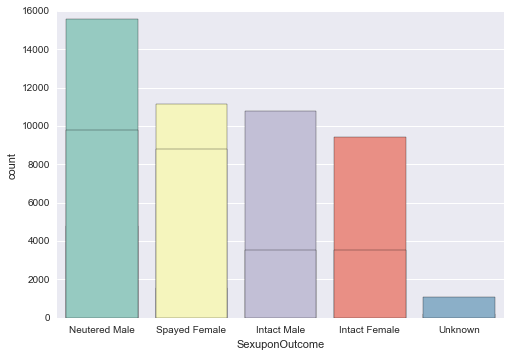

In [4]:
sns.countplot(train.AnimalType, palette='Set3')
sns.countplot(train.OutcomeType, palette='Set3')
sns.countplot(train.SexuponOutcome, palette='Set3')

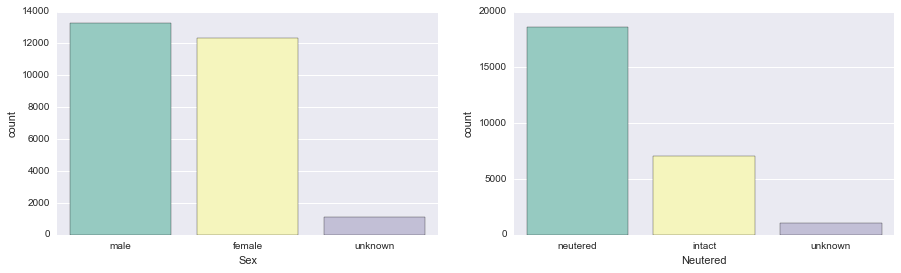

In [5]:
def get_sex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
def get_neutered(x):
    x = str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'
train['Sex'] = train.SexuponOutcome.apply(get_sex)
train['Neutered'] = train.SexuponOutcome.apply(get_neutered)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(train.Sex, palette='Set3', ax=ax1)
sns.countplot(train.Neutered, palette='Set3', ax=ax2)


#same distribution of sex, and most of them are neutered#

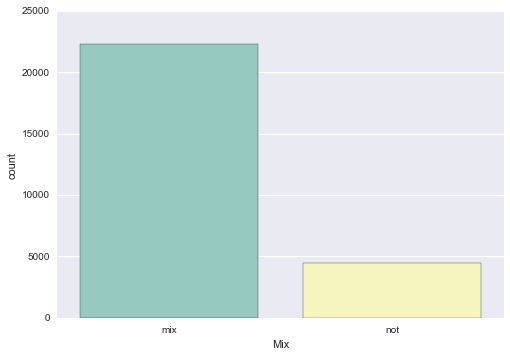

In [6]:
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'mix'
    return 'not'
train['Mix'] = train.Breed.apply(get_mix)
sns.countplot(train.Mix, palette='Set3')

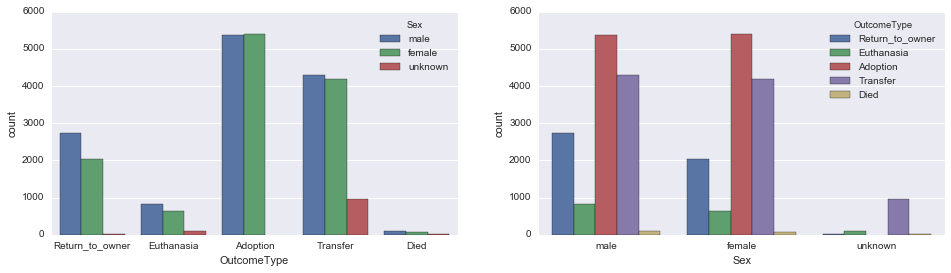

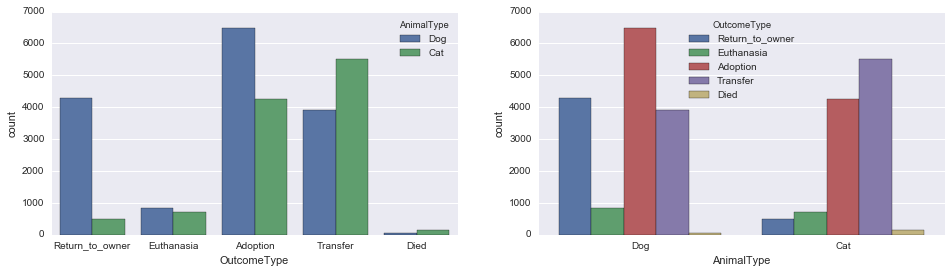

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=train, x='Sex',hue='OutcomeType', ax=ax2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AnimalType', ax=ax1)
sns.countplot(data=train, x='AnimalType',hue='OutcomeType', ax=ax2)

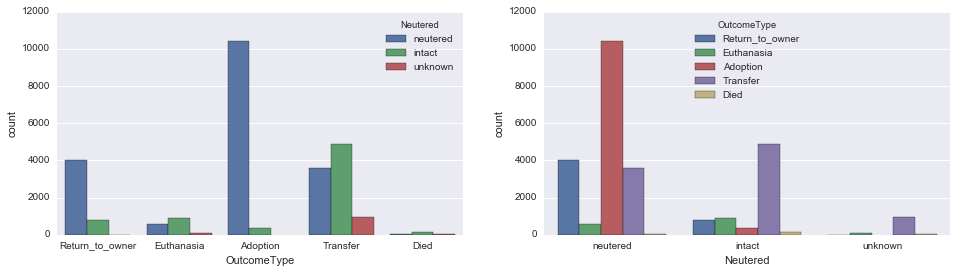

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='Neutered', ax=ax1)
sns.countplot(data=train, x='Neutered',hue='OutcomeType', ax=ax2)

#neutered animals have high chances to be adopted, while intact animals are more likely to be transferred#

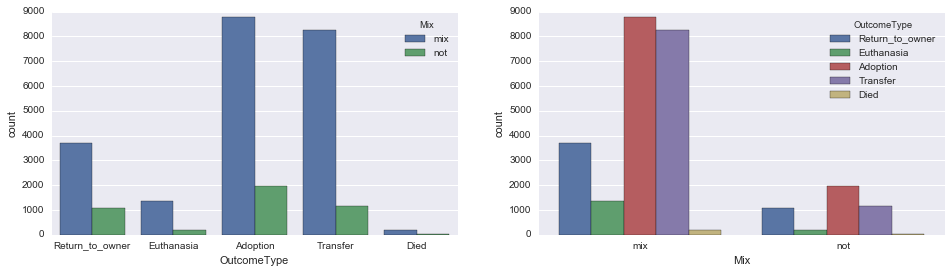

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='Mix', ax=ax1)
sns.countplot(data=train, x='Mix',hue='OutcomeType', ax=ax2)

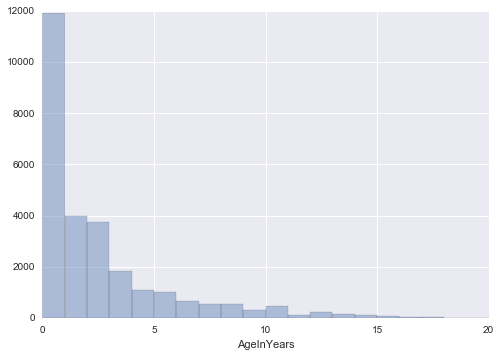

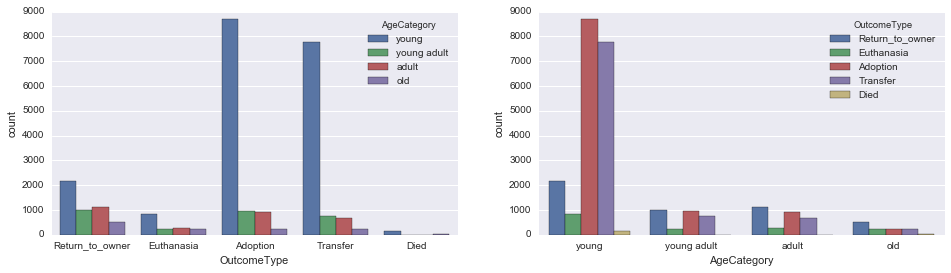

In [10]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0
train['AgeInYears'] = train.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(train.AgeInYears, bins = 20, kde=False)

def calc_age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
train['AgeCategory'] = train.AgeInYears.apply(calc_age_category)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AgeCategory', ax=ax1)
sns.countplot(data=train, x='AgeCategory',hue='OutcomeType', ax=ax2)


In [11]:
def check_has_name(name):
    if type(name) is str:
        return 1
    else:
        return 0
train["Has_Name"]= train["Name"].apply(check_has_name)
test["Has_Name"] = test["Name"].apply(check_has_name)

# Random Forest#

In [12]:
train.drop("DateTime",axis = 1, inplace = True)
test.drop("DateTime",axis = 1, inplace = True)
train.drop("OutcomeSubtype", axis = 1, inplace = True)
train_outcome = train["OutcomeType"]
train.drop("OutcomeType",axis = 1, inplace = True)
train["AgeuponOutcome"].fillna("1 year", inplace = True)
test["AgeuponOutcome"].fillna("1 year", inplace = True)
def age_group(age):
    try:
        age_list = age.split()
    except:
        return None
    if(age_list[1].find("s")):
        age_list[1] = age_list[1].replace("s","")
    age_list[0]= int(age_list[0])
    if age_list[1] == "day":
        return "Infant"
    elif age_list[1] == "month":
        return "Young"
    elif (age_list[0] >= 1 and age_list[0]<=10) and (age_list[1] == "year"):
        return "Adult"
    else:
        return "Senior"
train["AgeuponOutcome"] = train["AgeuponOutcome"].apply(age_group)
test["AgeuponOutcome"] = test["AgeuponOutcome"].apply(age_group)

In [13]:
train_id = train["AnimalID"]
test_id = train["AnimalID"]
train.drop("AnimalID",axis = 1, inplace = True)
test.drop("ID",axis = 1, inplace = True)

In [14]:
train.drop("Breed", axis = 1, inplace = True)
test.drop("Breed",axis = 1, inplace = True)
train.drop("Color", axis = 1, inplace = True)
test.drop("Color",axis = 1, inplace = True)
train.drop("Name", axis = 1 , inplace = True)
test.drop("Name",axis = 1, inplace = True)


train["train"] = 1
test["train"] = 0
all = pd.concat([train,test])
all_encoded = pd.get_dummies(all, columns = all.columns)
#Get the training data set with categorical variables encoded#
model_train = all_encoded[all_encoded["train_1"]==1]
# Get the testing data set with categorical variables encoded
model_test = all_encoded[all_encoded["train_0"]==1]
model_train.drop(["train_0","train_1"], axis=1, inplace=True)
model_test.drop(["train_0","train_1"], axis=1, inplace=True)

C:\Users\Jingru\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jingru\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
X_train, X_val, y_train, y_val = train_test_split(model_train, train_outcome, test_size=0.1)


forest = RandomForestClassifier(n_estimators = 200, n_jobs =2)
forest.fit(X_train,y_train)

y_probs = forest.predict_proba(X_val)
y_pred = forest.predict(X_val)
new_frame = pd.DataFrame(y_probs,columns =  ["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])

In [34]:
print y_pred

['Transfer' 'Adoption' 'Transfer' ..., 'Adoption' 'Transfer' 'Euthanasia']


In [18]:
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val,y_pred))
print(log_loss(y_val,y_probs))

             precision    recall  f1-score   support

   Adoption       0.66      0.84      0.74      1130
       Died       0.00      0.00      0.00        23
 Euthanasia       0.49      0.13      0.20       156
Return_to_owner       0.48      0.46      0.47       475
   Transfer       0.74      0.62      0.68       889

avg / total       0.64      0.65      0.63      2673

0.650579872802
1.12126666381


In [36]:
print y_val

8807            Transfer
10599           Adoption
6508            Transfer
17045    Return_to_owner
1684            Transfer
3775            Adoption
5295            Adoption
15047           Adoption
23356           Adoption
7889            Transfer
7490     Return_to_owner
6788            Transfer
17506           Adoption
22779           Adoption
25552           Transfer
13746         Euthanasia
13912           Transfer
21829           Adoption
7390            Adoption
19354           Adoption
19323           Transfer
1064     Return_to_owner
3645            Adoption
2450            Transfer
5859            Adoption
22384           Adoption
13033           Adoption
13406           Adoption
19862           Adoption
16841           Adoption
              ...       
5686          Euthanasia
2359            Adoption
17617    Return_to_owner
22138           Adoption
6785            Transfer
15995           Transfer
20299         Euthanasia
3343          Euthanasia
13963    Return_to_owner


In [25]:
forest = RandomForestClassifier(n_estimators=500, n_jobs=2)
forest.fit(model_train, train_outcome)
y_probs = forest.predict_proba(model_test)
results = pd.read_csv("C:/Users/Jingru/OneDrive/Thinkful/sample_submission.csv")
results["Adoption"] = y_probs[:,0]
results["Died"] = y_probs[:,1]
results["Euthanasia"] = y_probs[:,2]
results["Return_to_owner"] = y_probs[:,3]
results["Transfer"] = y_probs[:,4]
results.to_csv("C:/Users/Jingru/OneDrive/Thinkful/sample_submission.csv",index = False)
print results

          ID  Adoption      Died  Euthanasia  Return_to_owner  Transfer
0          1  0.176799  0.003692    0.089366         0.308336  0.421807
1          2  0.196988  0.002989    0.124695         0.486276  0.189053
2          3  0.237594  0.000752    0.130476         0.233981  0.397196
3          4  0.182077  0.007331    0.108512         0.318528  0.383553
4          5  0.178345  0.003406    0.130957         0.493863  0.193429
5          6  0.178345  0.003406    0.130957         0.493863  0.193429
6          7  0.212066  0.025026    0.207521         0.194629  0.360758
7          8  0.399474  0.022067    0.100183         0.099403  0.378873
8          9  0.290999  0.003285    0.085396         0.290425  0.329895
9         10  0.196988  0.002989    0.124695         0.486276  0.189053
10        11  0.290999  0.003285    0.085396         0.290425  0.329895
11        12  0.104194  0.003668    0.131159         0.471231  0.289749
12        13  0.290999  0.003285    0.085396         0.290425  0

In [26]:
len(model_train)

26729

In [27]:
len(train_outcome)

26729